In [26]:
import json, time, re, string, keras, pickle, h5py
import pandas as pd
import numpy as np
import tensorflow as tf

from numpy import random

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

%run ../assets/sql_cred.py

In [10]:
print(tf.test.gpu_device_name())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [11]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[0-z]+_[0-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

In [12]:
X_reshape = np.load('../assets/1549351379_LSTM315_Xreshape.npy')

In [13]:
y_cat = np.load('../assets/1549351379_LSTM315_ycat.npy')

In [14]:
with open('../assets/1549351379_LSTM_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [15]:
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

12978

In [ ]:
embeddings_index = dict()

f = open('../glove_data/glove.42B.300d.txt')

for line in f:
	values = line.split()
	word = values[0]
	coefs = cp.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs

f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))

for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	
    if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [12]:
seq_len=4

# Compile model
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=seq_len, mask_zero=True, trainable=False))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

In [13]:
# Train model on dataset
with tf.device('/gpu:0'):
    history = model.fit(X_reshape,
              y_cat,
              verbose=1,
              batch_size=5000,
              epochs=300, 
             )

Epoch 1/300
571513/571513 [==============================] - 100s 175us/step - loss: 6.3491 - acc: 0.1209
Epoch 2/300
571513/571513 [==============================] - 96s 168us/step - loss: 5.8121 - acc: 0.1234
Epoch 3/300
571513/571513 [==============================] - 96s 169us/step - loss: 5.7984 - acc: 0.1234
Epoch 4/300
571513/571513 [==============================] - 96s 169us/step - loss: 5.7888 - acc: 0.1234
Epoch 5/300
571513/571513 [==============================] - 97s 169us/step - loss: 5.7771 - acc: 0.1234
Epoch 6/300
571513/571513 [==============================] - 97s 169us/step - loss: 5.6898 - acc: 0.1249
Epoch 7/300
571513/571513 [==============================] - 97s 170us/step - loss: 5.2606 - acc: 0.1600
Epoch 8/300
571513/571513 [==============================] - 97s 170us/step - loss: 4.9157 - acc: 0.1879
Epoch 9/300
571513/571513 [==============================] - 97s 170us/step - loss: 4.6745 - acc: 0.2080
Epoch 10/300
571513/571513 [==========================

In [16]:
formatted_name, now, file_description= filename_format_log('../assets/LSTM315_model.h5')

model.save(formatted_name)

In [17]:
formatted_name, now, file_description= filename_format_log('../assets/LSTM315_weights.h5')
model.save_weights(formatted_name)

In [ ]:
# model = keras.models.load_model('../assets/1549265762_LSTM_Model.h5')

In [18]:
# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 3000)           38934000  
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 300)            3961200   
_________________________________________________________________
lstm_6 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 12978)             1310778   
Total params: 44,491,678
Trainable params: 44,491,678
Non-trainable params: 0
_________________________________________________________________
None


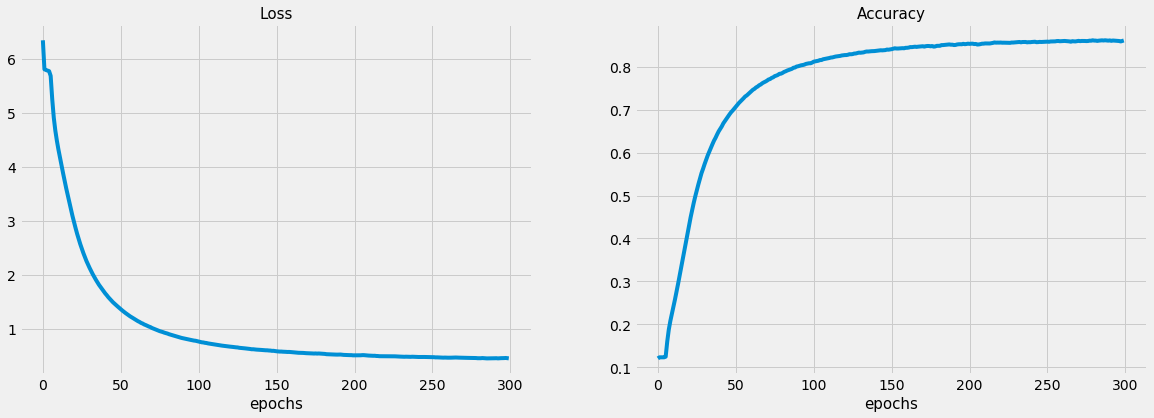

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].plot(history.history['loss'])
ax[0].set_title("Loss", fontsize=15);
ax[0].set_xlabel("epochs",fontsize=15);

ax[1].plot(history.history['acc'])
ax[1].set_title("Accuracy",fontsize=15);
ax[1].set_xlabel("epochs",fontsize=15);

In [21]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [17]:
def generate_lyrics(seed, 
                    seq_len = 4, 
                    song_len = 50,
                    temperature = 1.0,
                    model = None,
                    tokenizer = None,
                    model_dir = None, 
                    tokenizer_dir = None):
    
    if model_dir:
        model = keras.models.load_model(model_dir)
    else:
        model = model
    
    if tokenizer_dir: 
        with open(tokenizer_dir, 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        tokenizer = tokenizer
    
    seed_clean = seed.lower().split(' ')
    doc = []

    while len(doc) < song_len:
        text = [seed_clean]
        sequence = [tokenizer.texts_to_sequences([word])[0] for word in text]
        pad_sequence = pad_sequences(sequence, maxlen=seq_len, truncating='pre')
        sequence_reshape = np.reshape(pad_sequence, (1, seq_len))

        yhat = model.predict(sequence_reshape, verbose=0)[0]
        next_index = sample(yhat, temperature)
        
        for word, index in tokenizer.word_index.items():
            if index == next_index:
                seed_clean.append(word)
                doc.append(word)

    return ' '.join(doc)

In [23]:
lyrics = generate_lyrics('always be there love',
                         seq_len=4,
                         song_len=250,
                         model=model,
                         tokenizer=tokenizer
                        )
print(lyrics)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


me in the dark 
 its as long as its free 
 yeah she steals like a thief but shes always a woman to you 
 yes we both can get it out so hard 
 theres something im dreaming for 
 then i would say to you ah 
 baby you are the prototype 
 do something out of the ordinary 
 like catch a matine 
 baby you are with me 
 thirty days and counting 
 im going to look for you 
 now what am i supposed to do 
 when i put that pretty thing on you 
 i never should have loved and 
 youre the start i need a hold on you believe it 
 and thats the way it is 
 ha but dont you believe them 
 yes im loving you 
 part your friends to me 
 and ive been pretty crazy time 
 goin down to shine on ya 
 yeah you best 
 whats going over you its all over just to sing to me softly 
 cause then im outrunning the dark 
 thats as a wife and a family 
 you gave your ghost 
 to be alone with you 
 i dont need it 
 i aint even drunk bent 
 im an old skin for the desert beating 
 but we get along when im inside you 
 yeah yo